# Exercise 3

In [1]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

We are asked to analyse the following problem 

$$
\begin{align*}
u_t - \frac{1}{2}\sigma^2x^2u_{xx}-Rxu_x+cu=0, \qquad x\in \mathbb{R}^+, t\in(0,T),
\end{align*}
$$

where $\sigma, R, c > 0$ are volatility, interest rate, dividends and correlation. We have the following initial conditions:

$$
\begin{align*}
K&>0 \\ 
u(x,0) &= \text{max}(x-K,0)=:(x-k)^+ \\ 
u(x,0) &= \text{sgn}^+(x-k)
\end{align*}
$$

$\mathbb{R}^+$ is defined from $x=0$ to $x=\infty$. Since we can only solve the problem for a finite domain we have to create som artificial boundrys for the spatial grid. We let $x=0$ be the left side boundry, and let $R_B$ denote the right side boundry. We have the following boundry conditions 

$$
\begin{align*}
u(R_b,t) &= u(R_b,0) \\
u_x(R_b,t) &= u_x(R_b,0) \\
u_{xx}(R_b,t) &= 0 \\
\end{align*}
$$

We are asked to solve the artificial B.C's with central differences in space and Crank-Nicolson in time. We use the following operators 

$$
\begin{align*}
u_x &= \frac{U^n_{m+1}-U^n_{m-1}}{2h} \\
u_{xx} &= \frac{u^n_{m+1}-2U_m+U_{m-1}}{h^2}
\end{align*}
$$

When applying these operators to the original expression we get 

$$
U_{m+1}^{n+1}\left(-\frac{\sigma^2x^2}{4h^2} - \frac{Rx}{4h} \right) + U_{m}^{n+1} \left( \frac{1}{k} + \frac{\sigma^2x^2}{2h^2} + \frac{c}{2} \right) + U_{m-1}^{n+1} \left(-\frac{\sigma^2x^2}{4h^2} + \frac{Rx}{4h} \right) = U_{m+1}^{n}\left(\frac{\sigma^2x^2}{4h^2} + \frac{Rx}{4h} \right) + U_{m}^{n} \left(\frac{1}{k} - \frac{\sigma^2x^2}{2h^2} - \frac{c}{2} \right) + U_{m-1}^{n} \left(\frac{\sigma^2x^2}{4h^2} - \frac{Rx}{4h} \right)
$$

which we can write in matrix form

$$
(I-A)U^{n+1} + \left(- \frac{k \sigma^2x^2}{4h^2} \pm \frac{kRx}{4h}\right) g^{n+1} = (I+A) U^{n} + \left(\frac{k\sigma^2x^2}{4h^2} \mp \frac{kRx}{4h}\right) g^n
$$

where

$$
\text{A} = 
\begin{bmatrix}
-\frac{k\sigma^2x^2}{2h^2} - \frac{kc}{2}& \frac{k\sigma^2x^2}{4h^2} + \frac{kRx}{4h} & 0 & \dots& & \space & 0\\
 \frac{k\sigma^2x^2}{4h^2} - \frac{kRx}{4h} & -\frac{k\sigma^2x^2}{2h^2} - \frac{kc}{2}& \frac{k\sigma^2x^2}{4h^2} + \frac{kRx}{4h} & 0 & \dots & \space & 0 \\
0 & \frac{k\sigma^2x^2}{4h^2} - \frac{kRx}{4h} & -\frac{k\sigma^2x^2}{2h^2} - \frac{kc}{2}& \frac{k\sigma^2x^2}{4h^2} + \frac{kRx}{4h}  & 0 & \dots & 0\\
\vdots \\
0 & \dots & \space & 0 & \frac{k\sigma^2x^2}{4h^2} - \frac{kRx}{4h} & -\frac{k\sigma^2x^2}{2h^2} - \frac{kc}{2}& \frac{k\sigma^2x^2}{4h^2} + \frac{kRx}{4h} \\
0 & \dots & \space & \space & 0 & \frac{k\sigma^2x^2}{4h^2} - \frac{kRx}{4h} & -\frac{k\sigma^2x^2}{2h^2} - \frac{ck}{2} \\
\end{bmatrix}
$$

where $A$ is defined for $i,j = 1, \dots, M-1$ and 
$$
g= \begin{bmatrix}
g_1 \\
0 \\
\vdots \\
0 \\ 
g_{R_{m-1}}
\end{bmatrix}
$$

where $G$ is defined for $i = 1, \dots, M-1$

In [2]:
# We deine a help function to create a tridiagonal matrix
def tridiag(v, d, w, N):
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

def tridiag_a(R,sigma,R_b,h,k,M):
    
    #Defining constants
    x=np.linspace(0,R_b,M+1, endpoint=True)
    
    #Creating an array for the upper diagonal 
    y=x[1:-2]
    a_U=(k*sigma**2*y**2)/(4*h**2) +(k*R*y)/(4*h)

    #Creating an array for the lower diagonal
    z=x[2:-1]
    a_L=(k*sigma**2*z**2)/(4*h**2)-(k*R*z)/(4*h)

    #Creating an array for the diagonal
    x=x[1:-1]
    a_D=(-k*sigma**2*x**2)/(2*h**2)-(c*k)/2
    A = np.diag(a_L,-1)+np.diag(a_D)+np.diag(a_U,1)
    return A

In [3]:
#We create a new object-class for IBVP
class IBVP(object): 
    def __init__(self, ga=0, gb=0, a=0, b=1, u0=0, f=0):
        self.ga = ga       # left boundary condition
        self.gb = gb       # right boundary condition
        self.a = a         # left boundary position 
        self.b = b         # right boundary position 
        self.u0 = u0       # initial condition
        self.f = f         # right hand side 

In [4]:
#Plotting function 
def plot_solution(x, t, U, txt='Solution'):
    
    fig, ax = plt.subplots(figsize = (10,10), subplot_kw={"projection": "3d"})
    T, X = np.meshgrid(t,x)
    ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt);

In [65]:
def crank_nicholson(IBVP, R=0.5, sigma=1, M=10, N=100, T=0.5):
    # Input: 
    #       IBVP: object with the initial and boundary values and right hand side 
    #       M, N: number of grid intervals in the x- and t directions
    #       T: end of integration
    # Output: 
    #       x, t: the gridpoints in the x- and t- directions 
    #       U: An array with the numerical solution.

    # Set the stepsizes
    h = (IBVP.b-IBVP.a)/M     # Stepsize in space
    k = T/N                   # Stepsize in time
    
    r = k/h**2
    # Print the stepsizes, and r=k/h^2.
    #print('h={:.4f}, k={:.4f}, r={:.4f}'.format(h,k,r))
    
    x = np.linspace(IBVP.a, IBVP.b, M+1)  # Gridpoints on the x-axis
    t = np.linspace(0,T,N+1)              # Gridpoints on the t-axis   
    U = np.zeros((M+1,N+1))               # Array to store the solution, boundaries included. 
    
    U[:,0] = IBVP.u0(x,0)                   # Initial values
    U[0,:] = IBVP.ga(0,t)                   # Boundary values
    U[-1,:] = IBVP.gb(IBVP.b,t)             # Boundary values
    
    ''
    g = np.zeros((M-1,N+1))
    g[0, :] = IBVP.ga(0,t)
    g[-1, :] = IBVP.gb(IBVP.b,t)
    
    s=np.zeros((M-1))
    s[0]=(k*sigma**2*x[1]**2)/(4*h**2) - (k*R*x[1])/(4*h)
    s[-1]=(k*sigma**2*x[-2]**2)/(4*h**2) + (k*R*x[-2])/(4*h)
    


    A = tridiag_a(R, sigma, IBVP.b,h,k,M);
    I = tridiag(0,1,0,M-1);
    
    for n in range(N):
        U[1:-1, n+1] = np.linalg.solve(I-A,(I+A)@U[1:-1,n] + s*(g[:,n] + g[:,n+1]) + 0.5*k*(IBVP.f(x[1:-1],t[n])+IBVP.f(x[1:-1],t[n+1])))
    return x, t, U


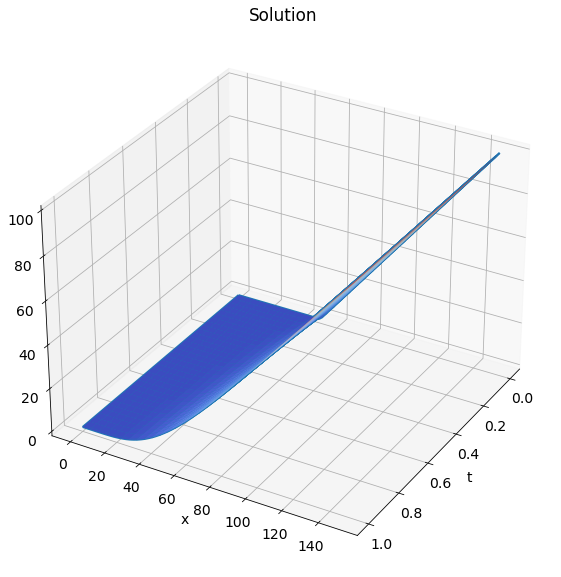

In [153]:
#Defining coefficents 
R = 0.05
sigma = 0.5
c = 0.05
K=50

T_time=1
M=100
N=100



#Initial condition for the dirchlet conditions: 
def uIC_EC_1(x,t):    #U initial condition European call   
    return np.maximum(np.ones(len(x))*(x-K), np.zeros(len(x)))
    
def g0_BC_D_1(x,t): #Boundary value x=0 at time t
    return (K*np.exp(-c*t))*0

def g1_BC_D_1(x,t): #Boundary value x=R at time t. We set it to 0 in the begining
    return np.ones(len(t+1))*100

def f_BC_D_1(x,t): 
    return  0*x


test_2 = IBVP(g0_BC_D_1, g1_BC_D_1, 0, 150, uIC_EC_1,f_BC_D_1)
x_1, t_1, U_1 = crank_nicholson(test_2, R, sigma, M, N, T_time)

plot_solution(x_1,t_1,U_1)

4.7243737972268995e-05


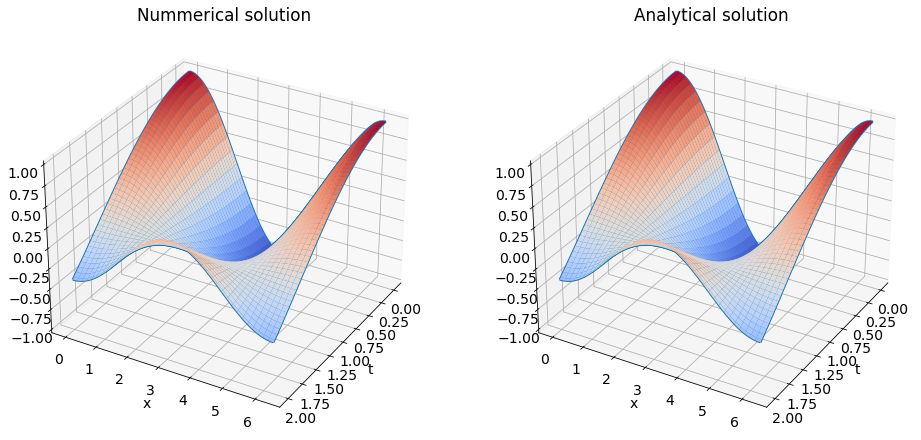

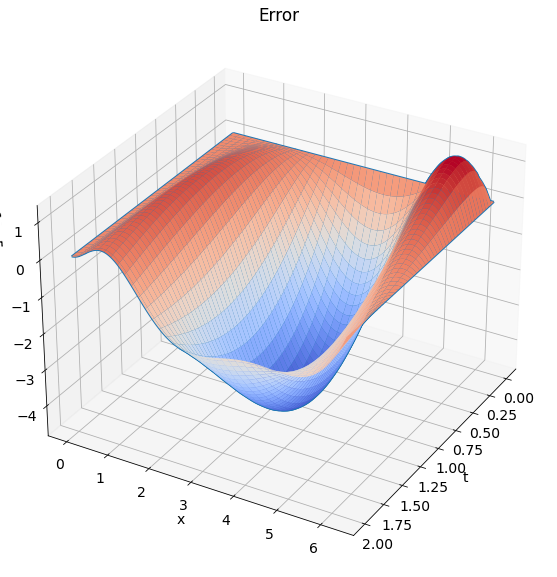

In [125]:
#Initial condition for the dirchlet conditions: 
def uIC_EC(x,t):    #U initial condition European call    
    return np.cos(x)*np.cos(t)

def g0_BC_D(x,t): #Boundary value x=0 at time t
    return np.cos(x)*np.cos(t)

def g1_BC_D(x,t): #Boundary value x=R at time t. We set it to 0 in the begining
    return np.cos(x)*np.cos(t)

def f_BC_D(x,t): 
    return  - np.cos(x)*np.sin(t) + 1/2*sigma**2*x**2*np.cos(t)*np.cos(x) + R*x*np.cos(t)*np.sin(x) + c*np.cos(t)*np.cos(x)

def u_solution(x,t):
    return np.cos(x)*np.cos(t)


T_time=2
M=200
N=5000
R = 0.05
sigma = 0.5
c = 0.15
K=0

test_1 = IBVP(g0_BC_D, g1_BC_D, 0, 2*np.pi, uIC_EC,f_BC_D)
x, t, U = crank_nicholson(test_1, R, sigma, M, N, T_time)

T, X = np.meshgrid(t,x)
solution = u_solution(X,T)

print(np.max(np.abs(solution-U)))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), subplot_kw={"projection": "3d"})

# First subplot
ax[0].plot_wireframe(T, X, U)
ax[0].plot_surface(T, X, U, cmap=cm.coolwarm)
ax[0].view_init(azim=30)
ax[0].set_xlabel('t')
ax[0].set_ylabel('x')
ax[0].set_title(r"Nummerical solution")

# Second subplot
ax[1].plot_wireframe(T, X, solution)
ax[1].plot_surface(T, X, solution, cmap=cm.coolwarm)
ax[1].view_init(azim=30)
ax[1].set_xlabel('t')
ax[1].set_ylabel('x')
ax[1].set_title(f"Analytical solution")

plt.show()

#Error plot
plot_solution(x, t, U-solution, txt='Error')

In [95]:
#Reuse convergence-tester from lecture-code 

def convergence_test_space(u_exact,heat_object, solver=crank_nicholson): 
    P = 4
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M = 20
    for p in range(P):
        x, t, U = solver(heat_object,R,sigma, M=M, N=10000, T=0.1)
        T, X = np.meshgrid(t,x)
        Eh = u_exact(X,T)-U
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        M = 2*M
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

x, t, U = solver(heat_object,R,sigma, M=M, N=10000, T=0.1)

In [130]:
test_1 = IBVP(g0_BC_D, g1_BC_D, 0, 10, uIC_EC,f_BC_D)

H, E, p = convergence_test_space(u_solution, test_1, crank_nicholson)


import pandas as pd #To format the output of the notebook.  
Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(H[1:]/H[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'h': H, 'Error': E ,'Rate':Rate}) 
df


,h,Error,Rate
0,0.50000000,0.00822747,0.00000000
1,0.25000000,0.00205830,1.99899810
2,0.12500000,0.00051465,1.99977724
3,0.06250000,0.00012867,1.99994613


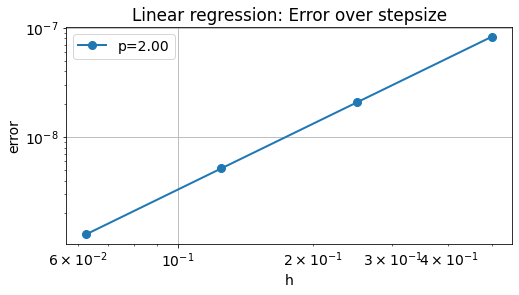

In [170]:
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.title("Linear regression: Error over stepsize")
plt.legend();

In [164]:
#We reuse the code from the lectures

# Find reference solution for semidiscrete problem (h fixed)
x, t, U_ref = crank_nicholson(test_1, M=20, N=50000, T=0.1)

# Refine in time
def convergence_time(U_ref, heat_object,solver=crank_nicholson): 
    P = 4
    Tconv = np.zeros(P)
    Econv = np.zeros(P)
    N = 400
    for p in range(P):
        x, t, U = solver(heat_object, M=20, N=N, T=0.1)
        Eh = U_ref[:,-1]-U[:,-1]
        Tconv[p] = (t[1]-t[0])
        Econv[p] = np.max(np.abs(Eh))
        N = 2*N
    order = np.polyfit(np.log(Tconv),np.log(Econv),1)[0]
    return Tconv, Econv, order

T, E, p = convergence_time(U_ref,test_1)

Rate=np.zeros(np.size(E))
Rate[1:]=np.log10(E[1:]/E[:-1])/np.log10(T[1:]/T[:-1])
pd.options.display.float_format = '{:.8f}'.format
df = pd.DataFrame(data={'h': T, 'Error': E ,'Rate':Rate}) 
df

,h,Error,Rate
0,0.00025000,0.00000008,0.00000000
1,0.00012500,0.00000002,2.00024737
2,0.00006250,0.00000001,2.00100032
3,0.00003125,0.00000000,2.00396767


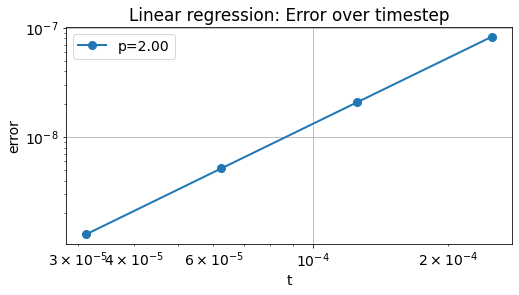

In [168]:
plt.loglog(T,E,'o-', label='p={:.2f}'.format(p))
plt.grid('on')
plt.xlabel('t')
plt.ylabel('error')
plt.title("Linear regression: Error over timestep")
plt.legend();